In [1]:
import numpy as np
import random
import pickle

import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
plt.style.use("ggplot")
plt.rcParams["text.usetex"] = True
plt.rcParams["text.latex.preamble"] = r"\usepackage{amsmath,bm}"
plt.rcParams["font.family"] = "serif"

# Phase oscillators code
from VanderPol1 import VdP, VdP_for_adjoint
from Phases import Phase_transform

# Fourier coefficient estimate
import Estimator_module
import Adjoint_module

# GP estimate
import tensorflow as tf
from tensorflow.python.ops.numpy_ops import np_config; np_config.enable_numpy_behavior()
import gpflow
from gpflow.utilities import print_summary, set_trainable
from gpflow.ci_utils import ci_niter
from GPRegression import run_adam

# config

In [2]:
# 系の設定
n_oscillator = 2 # 振動子の数
param_a1, param_a2 = 0.3, 0.7
param_K1, param_K2 = 0.01, 0.01
param_sigma = 0.03


# 推定に使う時系列の長さ  (\Delta \phi<= 2*pi*cycle)
n_cycle=1000

# hyper parameter
# 推定に使うハイパーパラメータを指定
alpha_0, beta_0 = 0.1, 0.1
## lambda_0が大きいほど関数の分散は明確に小さくなる. 基本的に0以上を設定
log10_lambda_0_min, log10_lambda_0_max = 1, 1
## 各PRCの次数
M_min, M_max = 0, 10

## SDE time step
dt = 0.01
t_end = 10000.0

## サンプリング間隔
sample_stride = 10
Dt = dt * sample_stride # Dt = 1.0

# Adjoint法

In [3]:
"""
ode1 = VdP_for_adjoint()
ode1.a = param_a1

init_x0=np.array([0.1, 0.1])
x0_marker1, period1 = ode1.phase_zero_marker_and_period(init_x0, Poincare_v=0.0) # 位相ゼロ点, 周期計算
adjoint_omega1 = (2.0*np.pi)/period1

adj_solver1 = Adjoint_module.Adjoint(ode1.F, ode1.J)
adj_solver1.grid = 2**10+1 
X1, tspan1 = adj_solver1.calculate_X(x0_marker1, period1)
adjoint_Z1 = adj_solver1.calculate_Z(X1, tspan1)
adjoint_phi1 = 2.0*np.pi*(tspan1/tspan1[-1])

ode2 = VdP_for_adjoint()
ode2.a = param_a2

init_x0=np.array([0.1, 0.1])
x0_marker2, period2 = ode2.phase_zero_marker_and_period(init_x0, Poincare_v=0.0) # 位相ゼロ点, 周期計算
adjoint_omega2 = (2.0*np.pi)/period2

adj_solver2 = Adjoint_module.Adjoint(ode2.F, ode2.J)
adj_solver2.grid = 2**10+1 
X2, tspan2 = adj_solver2.calculate_X(x0_marker2, period2)
adjoint_Z2 = adj_solver2.calculate_Z(X2, tspan2)
adjoint_phi2 = 2.0*np.pi*(tspan2/tspan2[-1])
"""

'\node1 = VdP_for_adjoint()\node1.a = param_a1\n\ninit_x0=np.array([0.1, 0.1])\nx0_marker1, period1 = ode1.phase_zero_marker_and_period(init_x0, Poincare_v=0.0) # 位相ゼロ点, 周期計算\nadjoint_omega1 = (2.0*np.pi)/period1\n\nadj_solver1 = Adjoint_module.Adjoint(ode1.F, ode1.J)\nadj_solver1.grid = 2**10+1 \nX1, tspan1 = adj_solver1.calculate_X(x0_marker1, period1)\nadjoint_Z1 = adj_solver1.calculate_Z(X1, tspan1)\nadjoint_phi1 = 2.0*np.pi*(tspan1/tspan1[-1])\n\node2 = VdP_for_adjoint()\node2.a = param_a2\n\ninit_x0=np.array([0.1, 0.1])\nx0_marker2, period2 = ode2.phase_zero_marker_and_period(init_x0, Poincare_v=0.0) # 位相ゼロ点, 周期計算\nadjoint_omega2 = (2.0*np.pi)/period2\n\nadj_solver2 = Adjoint_module.Adjoint(ode2.F, ode2.J)\nadj_solver2.grid = 2**10+1 \nX2, tspan2 = adj_solver2.calculate_X(x0_marker2, period2)\nadjoint_Z2 = adj_solver2.calculate_Z(X2, tspan2)\nadjoint_phi2 = 2.0*np.pi*(tspan2/tspan2[-1])\n'

# 結合関数計算

In [4]:
def V_12(x_r, x_s):
    """ x_r:x_1, x_s:x_2
    SDEの結合と整合性があることを確認！"""
    K = param_K1 # param_K1はグローバル
    u_r, v_r = x_r
    u_s, v_s = x_s
    return np.array([K*(u_s-u_r), K*(u_s**2)*v_s])

def V_21(x_r, x_s):
    """ x_r:x_2, x_s:x_1
    SDEの結合と整合性があることを確認！"""
    K = param_K2 # param_K2はグローバル
    u_r, v_r = x_r
    u_s, v_s = x_s
    return np.array([-K*(u_s**2)*v_s, K*u_s*(v_s**2)])
        

# adjoint_Gamma1 = Adjoint_module.Calculater_Gamma(V_12, adjoint_phi1, X1, X2, adjoint_Z1)
# adjoint_Gamma2 = Adjoint_module.Calculater_Gamma(V_21, adjoint_phi2, X2, X1, adjoint_Z2)

# theories = [(adjoint_phi1, adjoint_Gamma1+adjoint_omega1), (adjoint_phi2, adjoint_Gamma2+adjoint_omega2)]
# with open("vdp.pickle", "wb") as f:
#     pickle.dump(theories, f)
with open("vdp.pickle", "rb") as f:
    theories = pickle.load(f)

# SDE計算用の初期値を用意

In [5]:
# ODEの定義
tmp_c = VdP()
tmp_c.a1 = param_a1;  tmp_c.a2 = param_a2
tmp_c.K1 = param_K1;  tmp_c.K2 = param_K2
tmp_c.sigma = 0.0
tmp_tspan = np.arange(0.0, 100, 0.01)
# 解く!!!!!!!!
ans = tmp_c.solve_SDE(np.random.randn(4), tmp_tspan)
# transientを切る
idx_cutoff = 5000
ans_cutoff = ans[idx_cutoff:]; n_ans = ans_cutoff.shape[0]
# randomly select initial value with some noise
n_init = 50
idx_init = random.choices(np.arange(n_ans), k=n_init)
xs_init = ans_cutoff[idx_init] + 0.05*np.random.randn(*ans_cutoff[idx_init].shape)

# SDE計算

In [6]:
x0 = xs_init[0]
t_max = 6.3184*n_cycle
tspan = np.arange(0.0, t_max, dt)

c = VdP()
c.a1 = param_a1;  c.a2 = param_a2
c.K1 = param_K1;  c.K2 = param_K2
c.sigma = param_sigma

result = c.solve_SDE(x0, tspan)
# np.save("vdp_yoneda01", result) # データ保存
# result = np.load("vdp_yoneda01.npy")
u1, v1 = result[:,0], result[:,1]
u2, v2 = result[:,2], result[:,3]

# 位相作成

In [7]:
# サンプリング
tspan_stride = tspan[::sample_stride]
u1_stride, v1_stride = u1[::sample_stride], v1[::sample_stride]
u2_stride, v2_stride  = u2[::sample_stride], v2[::sample_stride]

# proto-phase (angle)  # -u+v*1j
sig1 = -u1_stride+v1_stride*1j; sig2 = -u2_stride+v2_stride*1j
proto_phase1 = np.angle(sig1 - sig1.mean())
proto_phase2 = np.angle(sig2 - sig2.mean())

# 位相を求める
pt = Phase_transform()
Sm1 = pt.calculate_Sm(proto_phase1)
phase1 = np.unwrap(pt.kralemann_phase(proto_phase1, Sm1))
Sm2 = pt.calculate_Sm(proto_phase2)
phase2 = np.unwrap(pt.kralemann_phase(proto_phase2, Sm2))
# 推定用の位相時系列
P = np.vstack([phase1, phase2]).T

# Fourier coefficient estimation

In [8]:
v1_mean = (P[-1,0] - P[0,0]) / (tspan[-1] - tspan[0])
v2_mean = (P[-1,1] - P[0,0]) / (tspan[-1] - tspan[0])

# receiver:1
Estimator1 = Estimator_module.Estimator(receiver=0, N=2,
                                        M_min=M_min, M_max=M_max,
                                        log10_lambda_0_min=log10_lambda_0_min, 
                                        log10_lambda_0_max=log10_lambda_0_max,  
                                        alpha_0=alpha_0, beta_0=beta_0)

Estimator1.set_init_all(v1_mean) # set intial condition (initial condition of omega)
Estimator1.update_all(P, delta_t=Dt) # update
result_model1, _ = Estimator1.model_selection() # model selection
# receiver:2
Estimator2 = Estimator_module.Estimator(receiver=1, N=2,
                                        M_min=M_min, M_max=M_max,
                                        log10_lambda_0_min=log10_lambda_0_min, 
                                        log10_lambda_0_max=log10_lambda_0_max,  
                                        alpha_0=alpha_0, beta_0=beta_0)
Estimator2.set_init_all(v2_mean) # set intial condition (initial condition of omega)
Estimator2.update_all(P, delta_t=Dt) # update
result_model2, _ = Estimator2.model_selection() # model selection

# データ整理
G1m, G1s, phi  = result_model1.return_Gamma(sender=1)
O1m, O1s = result_model1.return_omega()
Gamma1_order = result_model1.return_Gamma_order(sender=1)
G2m, G2s, _   = result_model2.return_Gamma(sender=0)
O2m, O2s = result_model2.return_omega()
Gamma2_order = result_model2.return_Gamma_order(sender=0)
otas = [(phi, G1m+O1m, G1s, Gamma1_order), (phi, G2m+O2m, G2s, Gamma2_order)]

# GP regression estimation

In [9]:
p1, p2 = P[:,0], P[:,1]
trains = [[np.mod(p2-p1, 2*np.pi)[:-1], np.diff(p1)/Dt], [np.mod(p1-p2, 2*np.pi)[:-1], np.diff(p2)/Dt]]
ms, logfs = [], []
for reciever in range(n_oscillator):
    data = trains[reciever]
    minibatch_size = 100
    n_data = (len(data[1])//minibatch_size)*minibatch_size
    X = data[0].reshape(-1, 1)[:n_data,:]
    Y = data[1].reshape(-1, 1)[:n_data,:]
    d = (X, Y)

    M = 50  # Number of inducing locations
    k = gpflow.kernels.Periodic(gpflow.kernels.SquaredExponential(), period=2*np.pi)
    set_trainable(k.period, False) # 周期関数の周期は固定(2π)
    Z = np.linspace(0, 2*np.pi, M).reshape(-1, 1)
    m = gpflow.models.SVGP(k, gpflow.likelihoods.Gaussian(), Z, num_data=n_data)

    maxiter = ci_niter(10000)
    logf = run_adam(m, maxiter, d, minibatch_size)
    ms.append(m)
    logfs.append(logf)

# データ整理
gps = []
pX = np.linspace(0, 2*np.pi, 100)[:, None]  # Test locations
for i in range(n_oscillator):
    pY, pYv = ms[i].predict_y(pX)  # Predict Y values at test locations
    gps.append((pX.reshape(-1), pY.reshape(-1), pYv.reshape(-1)))

100%|██████████| 10000/10000 [00:15<00:00, 639.09it/s]


# PLOT

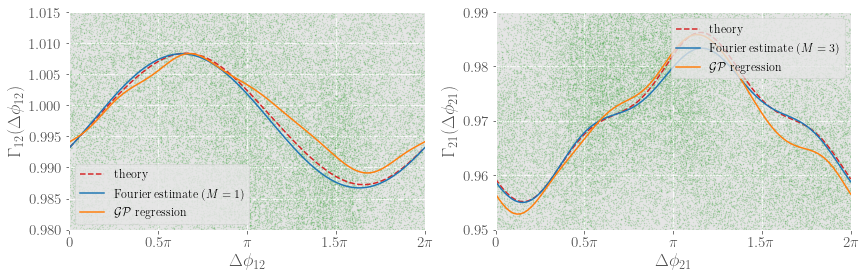

In [10]:
plt.figure(figsize=[14, 4])
plt.rcParams["font.size"] = 15
xlabels = [r"$\Delta \phi_{12}$", r"$\Delta \phi_{21}$"]
ylabels = [r"$\Gamma_{12}(\Delta \phi_{12})$", r"$\Gamma_{21}(\Delta \phi_{21})$"]
ylims = [(0.98, 1.015), (0.95, 0.99)]
for i in range(n_oscillator):
    plt.subplot(1, n_oscillator, i+1)
    plt.xlim(0,2*np.pi)
    plt.ylim(*ylims[i])
    plt.xlabel(xlabels[i])
    plt.ylabel(ylabels[i])
    plt.xticks([0, 0.5*np.pi, np.pi, 1.5*np.pi, 2.0*np.pi], [r"$0$", r"$0.5\pi$", r"$\pi$", r"$1.5\pi$", r"$2\pi$"])
    plt.plot(*theories[i], c="tab:red", ls="dashed", label="theory") # theories
    plt.plot(*otas[i][:2], c="tab:blue", label=rf"Fourier estimate ($M={otas[i][-1]}$)") # Fourier coefficient method
    plt.plot(*gps[i][:2], c="tab:orange", label="$\mathcal{GP}$ regression") # GP regression
    plt.scatter(*trains[i], color="tab:green", s=1, alpha=0.1)
    plt.legend(fontsize=12)
# plt.savefig("figs/exp02.pdf", bbox_inches="tight")

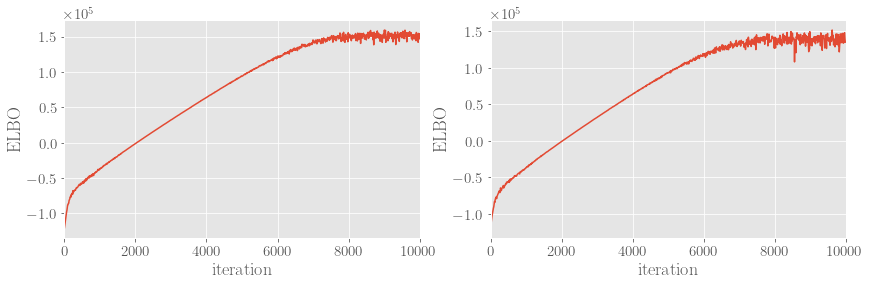

In [11]:
plt.figure(figsize=[14,4])
plt.rcParams["font.size"] = 15
for i in range(n_oscillator):
    plt.subplot(1, n_oscillator, i+1)
    plt.xlim(0, maxiter)
    plt.plot(np.arange(maxiter)[::10], logfs[i])
    ax = plt.gca()
    ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax.ticklabel_format(style="sci",  axis="y",scilimits=(0,0))
    plt.xlabel("iteration")
    plt.ylabel("ELBO")